In [1]:
CITY = 2507507
CITY_NAME = 'João Pessoa'
STATE = 'PB'
FILENAME_DATA = f'../../data/dengue_{CITY}_cluster.csv'
FILE_CHIK = f'../../data/chik_{CITY}_cluster.csv'

In [2]:
import sys
import pickle
sys.path.append('../..')
import numpy as np
import tensorflow as tf
import pandas as pd
from datetime import datetime
from pgbm_model import pgbm_pred
import matplotlib.pyplot as plt
from preprocessing import get_nn_data
from lstm import build_model, make_pred
from plots_lstm import plot_loss, plot_comp 
from sklearn.metrics import mean_squared_error as mse 

In [3]:
df_dengue = pd.read_csv(FILENAME_DATA, index_col = 'Unnamed: 0' )
df_dengue.index = pd.to_datetime(df_dengue.index)
df_dengue

,casos_2511103,casos_est_2511103,casos_est_min_2511103,casos_est_max_2511103,p_rt1_2511103,p_inc100k_2511103,temp_min_2511103,temp_max_2511103,umid_min_2511103,pressao_min_2511103,...,casos_2502151,casos_est_2502151,casos_est_min_2502151,casos_est_max_2502151,p_rt1_2502151,p_inc100k_2502151,temp_min_2502151,temp_max_2502151,umid_min_2502151,pressao_min_2502151
2010-01-03,0,0.0,0,0,0.000000,0.00000,21.729566,31.557818,46.931300,0.996315,...,0,0.0,0,0,0.000000,0.000000,21.738957,31.729963,46.241944,0.996288
2010-01-10,0,0.0,0,0,0.000000,0.00000,21.281668,30.062966,50.423419,0.997110,...,0,0.0,0,0,0.000000,0.000000,21.265948,30.022478,50.350168,0.997178
2010-01-17,0,0.0,0,0,0.000000,0.00000,21.253671,31.024864,46.237324,0.998092,...,0,0.0,0,0,0.000000,0.000000,21.469417,30.848798,47.002854,0.998225
2010-01-24,0,0.0,0,0,0.000000,0.00000,21.149841,29.572065,59.198893,0.997034,...,0,0.0,0,0,0.000000,0.000000,21.279423,29.891706,57.686070,0.997251
2010-01-31,0,0.0,0,0,0.000000,0.00000,22.371983,31.128226,51.700630,0.995794,...,0,0.0,0,0,0.000000,0.000000,22.304238,31.093772,52.040264,0.996023
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-03-19,0,0.0,0,0,0.000000,0.00000,21.834682,29.008676,56.809096,0.997182,...,0,0.0,0,0,0.000000,0.000000,21.913404,29.877729,52.756304,0.996908
2023-03-26,0,0.0,0,0,0.000000,0.00000,21.220830,29.040907,58.946110,0.997985,...,1,1.0,1,1,0.617693,14.013453,21.380293,29.182652,58.818106,0.998025
2023-04-02,2,2.0,2,2,0.977982,25.31966,20.860038,29.169460,57.238036,0.997669,...,0,0.0,0,0,0.000000,0.000000,20.986542,29.398860,55.340006,0.997911
2023-04-09,1,1.0,1,1,0.688757,12.65983,21.344979,29.065552,60.965549,0.996402,...,0,0.0,0,0,0.000000,0.000000,21.661068,29.409720,56.815284,0.996388


## Neural network model 

Parameters of the models:

In [4]:
END_TRAIN_DATE = '2020-12-28' # assign the last day used to evaluate the dengue model 
END_DATE = '2023-01-01'

PREDICT_N = 4 # number of new days predicted
LOOK_BACK = 4 # number of last days used to make the prediction 
BATCH_SIZE = 1
EPOCHS = 400
HIDDEN = 8
FEAT = 140 # number of features
l1 = 1e-6
l2 = 1e-6

Let's train the model with the loss function == msle 

Compilation Time :  0.0035271644592285156
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 4, 140)]          0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 4, 8)             9536      
 nal)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 4, 8)              0         
                                                                 
 lstm_1 (LSTM)               (None, 8)                 544       
                                                                 
 dropout_2 (Dropout)         (None, 8)                 0         
                                                                 
 dense (Dense)               (None, 4)                 36        
                   

2023-05-07 00:03:55.541228: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


120/120 [==============================] - 2s 6ms/step - loss: 0.0207 - accuracy: 0.3146 - mape: 7215742.5000 - mse: 0.0320 - val_loss: 0.0153 - val_accuracy: 0.2000 - val_mape: 5898890.0000 - val_mse: 0.0254
Epoch 2/400
120/120 [==============================] - 0s 4ms/step - loss: 0.0099 - accuracy: 0.2292 - mape: 3559658.7500 - mse: 0.0162 - val_loss: 0.0075 - val_accuracy: 0.2706 - val_mape: 1416738.8750 - val_mse: 0.0126
Epoch 3/400
120/120 [==============================] - 0s 3ms/step - loss: 0.0059 - accuracy: 0.2625 - mape: 1279595.6250 - mse: 0.0092 - val_loss: 0.0058 - val_accuracy: 0.3294 - val_mape: 144289.4062 - val_mse: 0.0090
Epoch 4/400
120/120 [==============================] - 0s 3ms/step - loss: 0.0051 - accuracy: 0.2438 - mape: 1462278.5000 - mse: 0.0077 - val_loss: 0.0050 - val_accuracy: 0.1882 - val_mape: 2401028.7500 - val_mse: 0.0072
Epoch 5/400
120/120 [==============================] - 0s 3ms/step - loss: 0.0050 - accuracy: 0.2875 - mape: 2274059.2500 - mse: 

120/120 [==============================] - 0s 3ms/step - loss: 0.0028 - accuracy: 0.3417 - mape: 1244054.7500 - mse: 0.0039 - val_loss: 0.0038 - val_accuracy: 0.3059 - val_mape: 964307.9375 - val_mse: 0.0059
Epoch 39/400
120/120 [==============================] - 0s 3ms/step - loss: 0.0029 - accuracy: 0.3229 - mape: 754206.4375 - mse: 0.0042 - val_loss: 0.0042 - val_accuracy: 0.3765 - val_mape: 1472245.1250 - val_mse: 0.0066
Epoch 40/400
120/120 [==============================] - 1s 4ms/step - loss: 0.0029 - accuracy: 0.3604 - mape: 1046123.4375 - mse: 0.0041 - val_loss: 0.0034 - val_accuracy: 0.3176 - val_mape: 919176.7500 - val_mse: 0.0049
Epoch 41/400
120/120 [==============================] - 0s 4ms/step - loss: 0.0030 - accuracy: 0.3292 - mape: 1723798.6250 - mse: 0.0043 - val_loss: 0.0035 - val_accuracy: 0.3529 - val_mape: 140952.8750 - val_mse: 0.0056
Epoch 42/400
120/120 [==============================] - 0s 3ms/step - loss: 0.0029 - accuracy: 0.3083 - mape: 1641347.1250 - mse:

120/120 [==============================] - 1s 5ms/step - loss: 0.0025 - accuracy: 0.3625 - mape: 1305506.6250 - mse: 0.0035 - val_loss: 0.0042 - val_accuracy: 0.3059 - val_mape: 803032.9375 - val_mse: 0.0068
Epoch 76/400
120/120 [==============================] - 1s 5ms/step - loss: 0.0026 - accuracy: 0.3167 - mape: 1351410.6250 - mse: 0.0036 - val_loss: 0.0035 - val_accuracy: 0.2706 - val_mape: 1289003.1250 - val_mse: 0.0052
Epoch 77/400
120/120 [==============================] - 1s 5ms/step - loss: 0.0027 - accuracy: 0.3771 - mape: 1162654.6250 - mse: 0.0039 - val_loss: 0.0047 - val_accuracy: 0.3529 - val_mape: 1286006.2500 - val_mse: 0.0078
Epoch 78/400
120/120 [==============================] - 1s 4ms/step - loss: 0.0027 - accuracy: 0.3750 - mape: 958306.6250 - mse: 0.0040 - val_loss: 0.0033 - val_accuracy: 0.2941 - val_mape: 485360.5312 - val_mse: 0.0049
Epoch 79/400
120/120 [==============================] - 1s 4ms/step - loss: 0.0027 - accuracy: 0.3500 - mape: 884517.6250 - mse:

120/120 [==============================] - 0s 3ms/step - loss: 0.0031 - accuracy: 0.3562 - mape: 919713.9375 - mse: 0.0046 - val_loss: 0.0026 - val_accuracy: 0.4000 - val_mape: 1408826.8750 - val_mse: 0.0036
Epoch 113/400
120/120 [==============================] - 0s 4ms/step - loss: 0.0024 - accuracy: 0.4083 - mape: 917516.1250 - mse: 0.0032 - val_loss: 0.0027 - val_accuracy: 0.3765 - val_mape: 726325.1875 - val_mse: 0.0038
Epoch 114/400
120/120 [==============================] - 0s 4ms/step - loss: 0.0024 - accuracy: 0.3875 - mape: 1005091.6250 - mse: 0.0033 - val_loss: 0.0039 - val_accuracy: 0.4588 - val_mape: 82909.7266 - val_mse: 0.0061
Epoch 115/400
120/120 [==============================] - 0s 3ms/step - loss: 0.0026 - accuracy: 0.3833 - mape: 1218026.2500 - mse: 0.0036 - val_loss: 0.0035 - val_accuracy: 0.3529 - val_mape: 599083.6875 - val_mse: 0.0052
Epoch 116/400
120/120 [==============================] - 0s 3ms/step - loss: 0.0022 - accuracy: 0.4187 - mape: 1367569.5000 - ms

120/120 [==============================] - 0s 3ms/step - loss: 0.0027 - accuracy: 0.3854 - mape: 842695.9375 - mse: 0.0039 - val_loss: 0.0034 - val_accuracy: 0.4471 - val_mape: 837961.8125 - val_mse: 0.0054
Epoch 150/400
120/120 [==============================] - 0s 3ms/step - loss: 0.0023 - accuracy: 0.4229 - mape: 1105158.8750 - mse: 0.0031 - val_loss: 0.0033 - val_accuracy: 0.4353 - val_mape: 801951.5000 - val_mse: 0.0048
Epoch 151/400
120/120 [==============================] - 0s 3ms/step - loss: 0.0026 - accuracy: 0.3938 - mape: 1052001.1250 - mse: 0.0038 - val_loss: 0.0031 - val_accuracy: 0.4588 - val_mape: 639676.4375 - val_mse: 0.0046
Epoch 152/400
120/120 [==============================] - 0s 3ms/step - loss: 0.0025 - accuracy: 0.4021 - mape: 852236.9375 - mse: 0.0036 - val_loss: 0.0040 - val_accuracy: 0.3765 - val_mape: 725857.1875 - val_mse: 0.0061
Epoch 153/400
120/120 [==============================] - 0s 3ms/step - loss: 0.0023 - accuracy: 0.3771 - mape: 1322483.3750 - ms

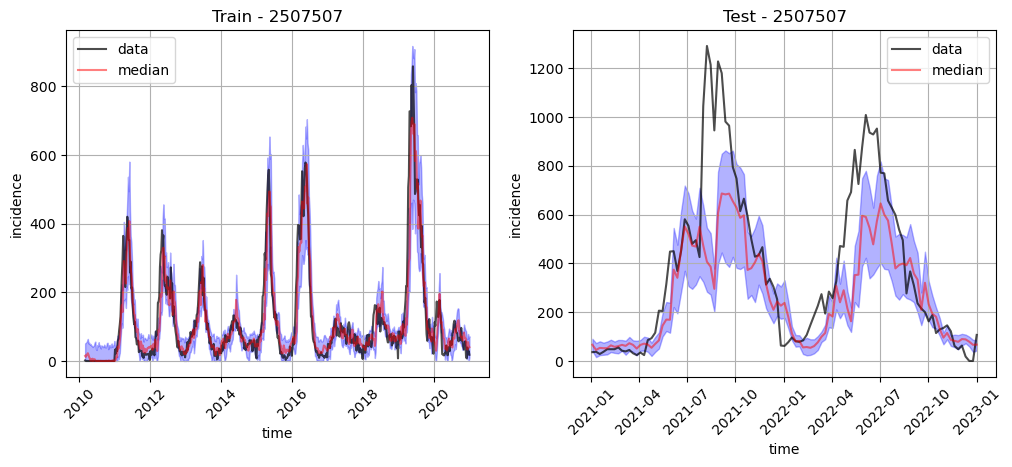

In [5]:
model = build_model(l1=l1, l2 = l2, hidden = HIDDEN, features = FEAT, predict_n = PREDICT_N, look_back=LOOK_BACK, batch_size=BATCH_SIZE, loss = 'msle', lr = 0.001)

m_msle_all, h_msle_all, m_train_all, m_val_all = make_pred(model, CITY, doenca = 'dengue', epochs = EPOCHS, end_train_date = END_TRAIN_DATE, 
                    ratio= None, end_date = END_DATE,
                     predict_n = PREDICT_N, look_back =  LOOK_BACK, label = 'msle_all',  filename = FILENAME_DATA)

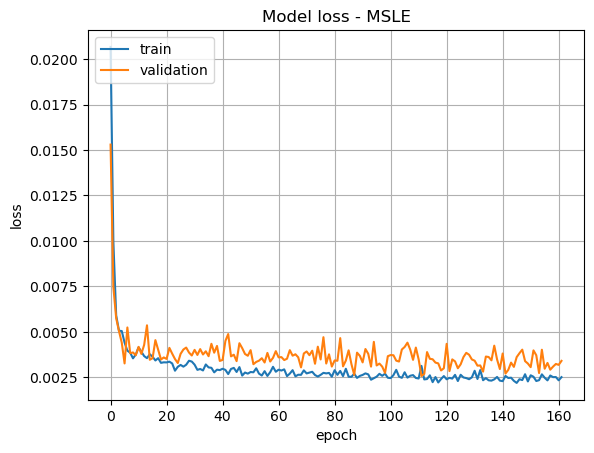

In [6]:
plot_loss(h_msle_all, title = 'Model loss - MSLE')

PGBM model

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


Estimator 0/100, Train metric: 87.0434
Estimator 1/100, Train metric: 79.3363
Estimator 2/100, Train metric: 72.3627
Estimator 3/100, Train metric: 66.0622
Estimator 4/100, Train metric: 60.3305
Estimator 5/100, Train metric: 55.1493
Estimator 6/100, Train metric: 50.4782
Estimator 7/100, Train metric: 46.2000
Estimator 8/100, Train metric: 42.3423
Estimator 9/100, Train metric: 38.8344
Estimator 10/100, Train metric: 35.6810
Estimator 11/100, Train metric: 32.8142
Estimator 12/100, Train metric: 30.1625
Estimator 13/100, Train metric: 27.7620
Estimator 14/100, Train metric: 25.6359
Estimator 15/100, Train metric: 23.6774
Estimator 16/100, Train metric: 21.8960
Estimator 17/100, Train metric: 20.2827
Estimator 18/100, Train metric: 18.8193
Estimator 19/100, Train metric: 17.4761
Estimator 20/100, Train metric: 16.2859
Estimator 21/100, Train metric: 15.1993
Estimator 22/100, Train metric: 14.2024
Estimator 23/100, Train metric: 13.3262
Estimator 24/100, Train metric: 12.5289
Estimator 

Estimator 10/100, Train metric: 37.4029
Estimator 11/100, Train metric: 34.6297
Estimator 12/100, Train metric: 32.0331
Estimator 13/100, Train metric: 29.6911
Estimator 14/100, Train metric: 27.5882
Estimator 15/100, Train metric: 25.6851
Estimator 16/100, Train metric: 23.9965
Estimator 17/100, Train metric: 22.4454
Estimator 18/100, Train metric: 20.9961
Estimator 19/100, Train metric: 19.6926
Estimator 20/100, Train metric: 18.5178
Estimator 21/100, Train metric: 17.4520
Estimator 22/100, Train metric: 16.4523
Estimator 23/100, Train metric: 15.5216
Estimator 24/100, Train metric: 14.6426
Estimator 25/100, Train metric: 13.8826
Estimator 26/100, Train metric: 13.1546
Estimator 27/100, Train metric: 12.5420
Estimator 28/100, Train metric: 12.0003
Estimator 29/100, Train metric: 11.4437
Estimator 30/100, Train metric: 10.9273
Estimator 31/100, Train metric: 10.5266
Estimator 32/100, Train metric: 10.0984
Estimator 33/100, Train metric: 9.6830
Estimator 34/100, Train metric: 9.3432
Es

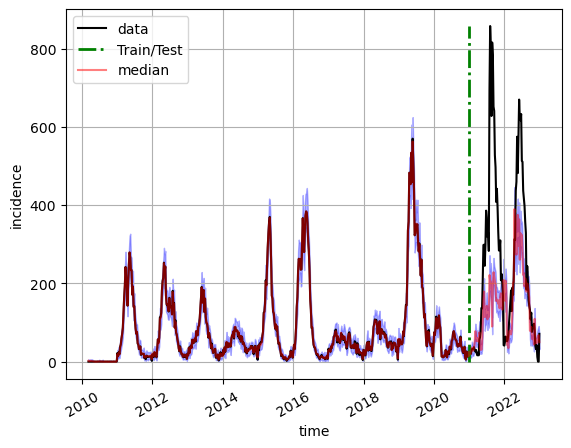

In [7]:
preds, preds25, preds975, X_train, targets = pgbm_pred(CITY, STATE, PREDICT_N, LOOK_BACK, doenca = 'dengue', ini_date = None, end_train_date = END_TRAIN_DATE, end_date = END_DATE,  filename = FILENAME_DATA)
   